# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 7th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 2 octobre 2017**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "Aymen"
ln1 = "MEJRI"
fn2 = "Ahmed"
ln2 = "BEJAOUI"

filename = "_".join(map(lambda s: s.strip().lower(),
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_mejri_aymen_and_bejaoui_ahmed.ipynb


### A few tactical imports and configurations

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import check_grad
from numpy.linalg import norm
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn
from numpy.linalg import solve

matplotlib.style.use('ggplot')
np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

# to embed figures in the notebook
%matplotlib inline
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

Text(0.5,1,'Parameters / Coefficients')

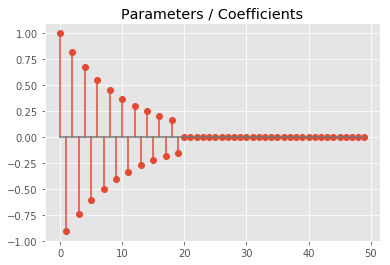

In [3]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [4]:
def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model

    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model

    n_samples : `int`, default=1000
        Number of samples to simulate

    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix

    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model

    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model

    n_samples : `int`, default=1000
        Number of samples to simulate

    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix

    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + g(z) \right\}.
$$


We have in mind to use the following cases

- Ridge penalization, where $g(z) = \frac{s}{2} \|z\|_2^2$
- Lasso penalization, where $g(z) = s \|z|\|_1$

where $s \geq 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 
    </li>
    </ul>
</div>

In [5]:
def prox_lasso(x, s):
    """Proximal operator for the Lasso at x"""
    n = x.shape[0]
    prox = np.zeros(n)
    for i in range(n):
        if x[i] > s:
            prox[i] = x[i] - s
        elif x[i] < (-1) * s:
            prox[i] = x[i] + s
        else:
            prox[i] = 0
    return prox


def lasso(x, s):
    """Value of the Lasso penalization at x"""
    res = s * np.linalg.norm(x, ord=1)
    return res


def prox_ridge(x, s):
    """Proximal operator for the ridge at x"""
    res = (1. / float(s + 1)) * x
    return res


def ridge(x, s):
    """Value of the ridge penalization at x"""
    res = (float(s) / 2.) * np.linalg.norm(x, ord=2)**2
    return res

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

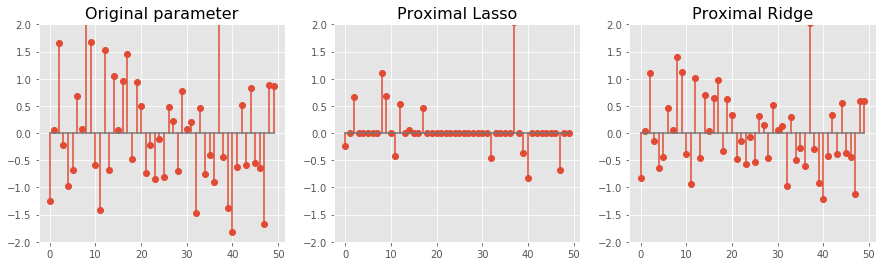

In [6]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

** Interprétation: **</br>
The proximal Lasso induces sparsity on the coeff compared to the original parameter. In fact, it defines a thresholding a threshold below which all values will be set to zero.
</br>
the proximal Ridge is used to control the size of the coefficient. Here we can notice that te amplitude of the coefficient has decreassed compared to the original ( in general, ridge is used to control variance)
 

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

### the gradient and  the objective function of Linear regression $f$
for linear regression regression we have
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
then 
$$\triangledown f = \frac{1}{n}A^T.(A x-b)$$

### the gradient and  the objective function of Logistic regression $f$
for logistic regression we have
$$f( x) = \frac{1}{n}\sum_{i=1}^n{log\left(1+ e^{-b_i\left(a_i^Tx\right)}\right)}$$

we denote $A$  by $ A= \begin{pmatrix}
                    a_1^T & \\ 
                    \vdots & \\
                    a_n^T & \\
\end{pmatrix}$

$$\triangledown f = \frac{1}{n}\sum_{i=1}^n{ \frac{ -b_ia_ie^{-b_ia_i^Tx}}{1+e^{-b_ia_i^Tx}}}$$
then  $$\triangledown f =  \frac{1}{n}\sum_{i=1}^n{\frac{ -b_i}{1+e^{b_ia_i^Tx}}a_i }$$



In [7]:
def loss_linreg(x):
    """Least-squares loss"""
    n=A.shape[0]
    f=(1./(2*n))*(A.dot(x)-b).T.dot(A.dot(x)-b)
    return f

def grad_linreg(x):
    """Leas-squares gradient"""
    n=A.shape[0]
    grad_f=(1./n)*A.T.dot(A.dot(x)-b)
    return grad_f

  
def loss_logreg(x):
    """Logistic loss"""
    n=A_log.shape[0]
    s=0
    for i in range(n):
        s=s+np.log(1+np.exp((-1)*b_log[i]*A_log[i,:].dot(x)))
    return s/n

  
def grad_logreg(x):
    """Logistic gradient"""
    n=A_log.shape[0]
    s=0
    for i in range(n):
        s=s-b_log[i]/(1+np.exp(b_log[i]*A_log[i,:].dot(x)))*A_log[i,:].T    
    return s/n

### Numerically checking the gradient of linear regression using the check_grad function

In [8]:
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
n = b.shape[0]
check_grad(loss_linreg, grad_linreg, coefs)

5.9274386070483884e-08

### Numerically checking the gradient of logistic regression using the check_grad function

In [9]:
A_log, b_log = simu_logreg(coefs, n_samples=1000, corr=0.5)
n = b_log.shape[0]
A, b = simu_linreg(coefs, n_samples=1000, corr=0.5)
check_grad(loss_logreg, grad_logreg, coefs)

3.6833145649762456e-07

## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `ista` and `fista` below that implements the 
  ISTA (Proximal Gradient Descent) and FISTA (Accelerated Proximal 
  Gradient Descent) algorithms</li>
    </ul>
</div>

### Computing the Lipschitz constants for linear and logistic regression losses

In [10]:
def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""
    u, s, vh = np.linalg.svd(A, full_matrices=False)
    n = b.shape[0]
    return max(s)**2 / n
# we can also obtain it with : return np.linalg.norm(A,2)/A.shape[0]


def lip_logreg(A):
    """Lipschitz constant for logistic loss"""
    n = A.shape[0]
    u, s, vh = np.linalg.svd(A, full_matrices=False)
    return max(s)**2 / (4 * n)
# we can also obtain it with: return np.linalg.norm(A,2)/(4*n)

### Implementing the ISTA (Proximal Gradient Descent) and FISTA (Accelerated Proximal Gradient Descent) 

In [11]:
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = np.zeros(x0.shape[0])
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x = prox_g(x - (1. / float(step)) * grad_f(x), float(s) / float(step))
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8),
                              ("%.2e" % obj).rjust(8),
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [12]:
def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
          x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()

    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x_new = prox_g(z - (1. / float(step)) * grad_f(z), s / step)
        t_new = (1 + np.sqrt(1 + (4 * t**2))) / 2
        z = x_new + (t - 1) / t_new * (x_new - x)
        x = x_new
        t = t_new

        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8),
                              ("%.2e" % obj).rjust(8),
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [13]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40
s = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using fista with 
  1000 iterations.</li>
    <li>Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

## Partie A:

In [14]:
A, b = simu_linreg(coefs)
A_log, b_log = simu_logreg(coefs)
# x_true=solve(A.T.dot(A)+s*np.eye(A.shape[1]),A.T.dot(b))

### Linear regression - Ridge : 


In [15]:
# a) find the true minimizer and the minimum : 
x_true,obj,err=ista(x0,loss_linreg,grad_linreg,ridge,prox_ridge,step=lip_linreg(A),s=s,n_iter=1000,verbose=False)

# b) Compare the convergences of ISTA and FISTA, in terms of distance to the minimum anddistance to the minimizer
x_ista_linreg_ridge,obj1,err1=ista(x0,loss_linreg,grad_linreg,ridge,prox_ridge,step=lip_linreg(A),s=s,n_iter=500,verbose=False,x_true=x_true)
x_fista_linreg_ridge,obj2,err2=fista(x0,loss_linreg,grad_linreg,ridge,prox_ridge,step=lip_linreg(A),x_true=x_true,s=s,n_iter=500,verbose=False)

Text(0.5,1,'Convergences of ISTA and FISTA, in terms of distance to the minimum')

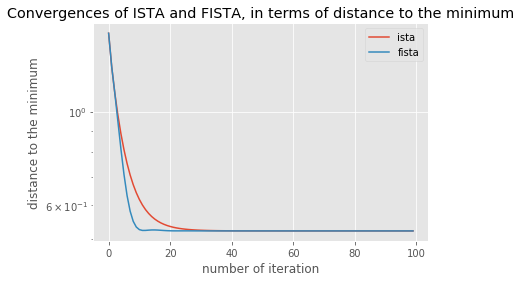

In [16]:
plt.plot(obj1[:100], label="ista")
plt.plot(obj2[:100], label="fista")
plt.legend()
plt.yscale('log')
plt.xlabel("number of iteration")
plt.ylabel("distance to the minimum")
plt.title("Convergences of ISTA and FISTA, in terms of distance to the minimum")

Text(0.5,1,'Convergences of ISTA and FISTA in terms of distance to the minimizer')

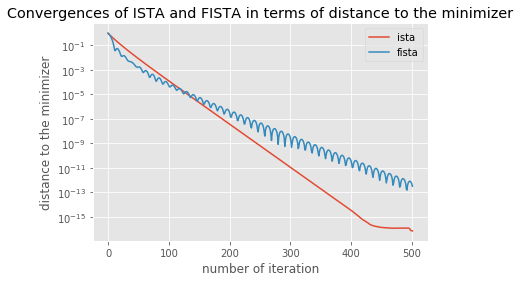

In [17]:
plt.plot(err1, label="ista")
plt.plot(err2, label="fista")
plt.legend()
plt.yscale('log')
plt.xlabel("number of iteration")
plt.ylabel("distance to the minimizer")
plt.title("Convergences of ISTA and FISTA in terms of distance to the minimizer")

### Linear_regression - Lasso


Text(0.5,1,'Convergences of ISTA and FISTA, in terms of distance to the minimum')

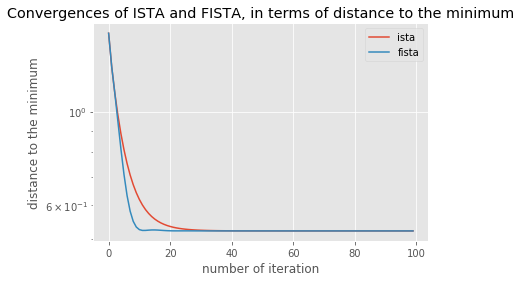

In [18]:
plt.plot(obj1[:100], label="ista")
plt.plot(obj2[:100], label="fista")
plt.legend()
plt.yscale('log')
plt.xlabel("number of iteration")
plt.ylabel("distance to the minimum")
plt.title("Convergences of ISTA and FISTA, in terms of distance to the minimum")

Text(0.5,1,'Convergences of ISTA and FISTA, in terms of distance to the minimum')

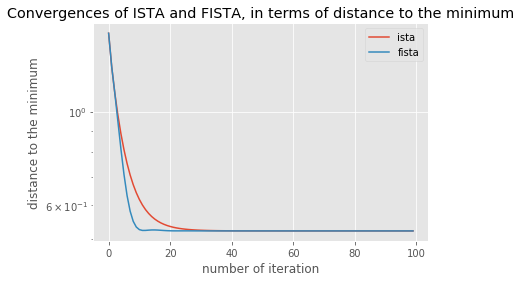

In [19]:
plt.plot(obj1[:100], label="ista")
plt.plot(obj2[:100], label="fista")
plt.legend()
plt.yscale('log')
plt.xlabel("number of iteration")
plt.ylabel("distance to the minimum")
plt.title("Convergences of ISTA and FISTA, in terms of distance to the minimum")

Text(0.5,1,'Convergences of ISTA and FISTA in terms of distance to the minimizer')

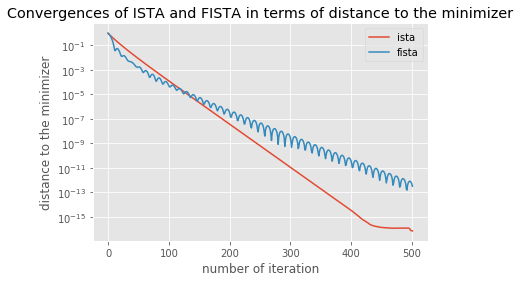

In [20]:
plt.plot(err1, label="ista")
plt.plot(err2, label="fista")
plt.legend()
plt.yscale('log')
plt.xlabel("number of iteration")
plt.ylabel("distance to the minimizer")
plt.title("Convergences of ISTA and FISTA in terms of distance to the minimizer")

### Logestic regression - Ridge :

In [21]:
# a) find the true minimizer and the minimum :
x_ista_logreg_ridge, obj1, err1 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step=lip_logreg(
    A_log), s=s, n_iter=100, verbose=False, x_true=x_true)


# b) Compare the convergences of ISTA and FISTA, in terms of distance to the minimum anddistance to the minimizer
x_fista_logreg_ridge, obj2, err2 = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step=lip_logreg(
    A_log), x_true=x_true, s=s, n_iter=100, verbose=False)  # a) find the true minimizer and the minimum :
x_true, obj, err = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge,
                        step=lip_logreg(A_log), s=s, n_iter=1000, verbose=False)

Text(0.5,1,'Convergences of ISTA and FISTA, in terms of distance to the minimum')

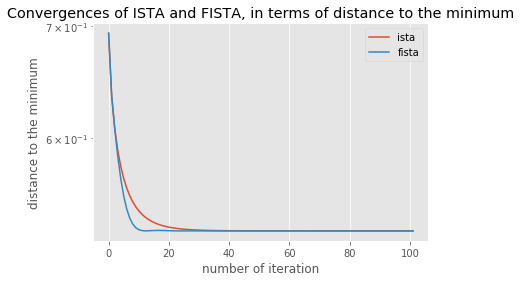

In [22]:
plt.plot(obj1, label="ista")
plt.plot(obj2, label="fista")
plt.legend()
plt.yscale('log')
plt.xlabel("number of iteration")
plt.ylabel("distance to the minimum")
plt.title("Convergences of ISTA and FISTA, in terms of distance to the minimum")

Text(0.5,1,'Convergences of ISTA and FISTA in terms of distance to the minimizer')

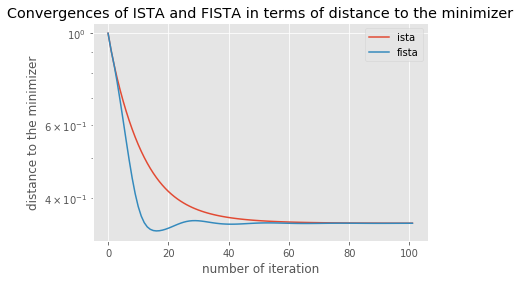

In [23]:
plt.plot(err1, label="ista")
plt.plot(err2, label="fista")
plt.legend()
plt.yscale('log')
plt.xlabel("number of iteration")
plt.ylabel("distance to the minimizer")
plt.title("Convergences of ISTA and FISTA in terms of distance to the minimizer")

### Logistic Regression - LASSO : 

In [24]:
# a) find the true minimizer and the minimum :
x_true, obj, err = ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso,
                        step=lip_logreg(A_log), s=s, n_iter=1000, verbose=False)

# b) Compare the convergences of ISTA and FISTA, in terms of distance to the minimum anddistance to the minimizer
x_ista_logreg_lasso, obj1, err1 = ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step=lip_logreg(
    A_log), s=s, n_iter=500, verbose=False, x_true=x_true)
x_fista_logreg_lasso, obj2, err2 = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step=lip_logreg(
    A_log), x_true=x_true, s=s, n_iter=500, verbose=False)

Text(0.5,1,'Convergences of ISTA and FISTA, in terms of distance to the minimum')

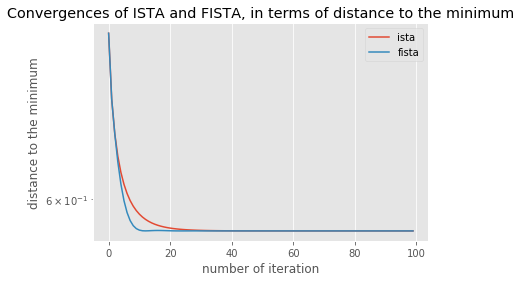

In [25]:
plt.plot(obj1[:100], label="ista")
plt.plot(obj2[:100], label="fista")
plt.legend()
plt.yscale('log')
plt.xlabel("number of iteration")
plt.ylabel("distance to the minimum")
plt.title("Convergences of ISTA and FISTA, in terms of distance to the minimum")

Text(0.5,1,'Convergences of ISTA and FISTA in terms of distance to the minimizer')

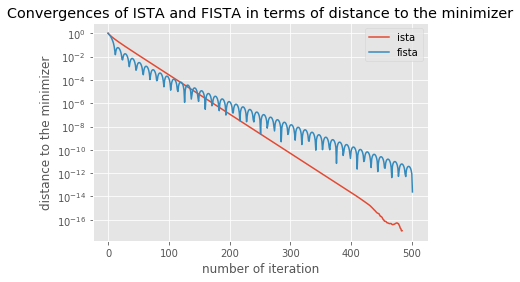

In [26]:
plt.plot(err1, label="ista")
plt.plot(err2, label="fista")
plt.legend()
plt.yscale('log')
plt.xlabel("number of iteration")
plt.ylabel("distance to the minimizer")
plt.title("Convergences of ISTA and FISTA in terms of distance to the minimizer")

** Interprétation: **
</br>
*In term of minimum:*
</br>regardless of the type of the penalty and the regression function, we notice that fista algoritm converges faster than the ista algoritm.This result is predictible because: 
</br>
In the ista algorithm, the convergence rate is equal to $O(\frac{1}{T})$ however in the Fista algorithm, the convergence rate is equal to  $O(\frac{1}{T^2})$
</br>
*In term of minimizer:*
</br>
In the beginning, the fista algorithm performs better than the ista algoritm. but after 200 iterations (approximately, the ista algorithm will become better than the ista algoritm in terms of distance to the minimizer 


<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    <li>In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain</li>
    </ul>
</div>

### Exercise :

### A) Compare the solution you obtain with ista and fista with the true parameter coefs of the model. 

#### Linear regression - Ridge : 

Text(0.5,1,'Comparaison between X_ista and X_fista in the case of Linear regression - Ridge')

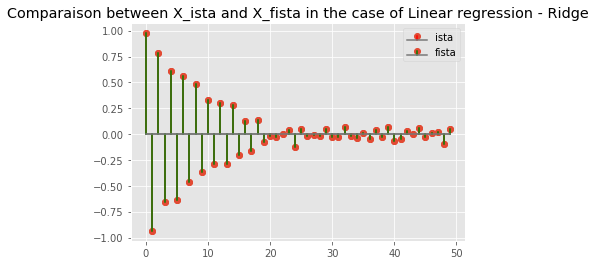

In [27]:
x_ista_linreg_ridge, obj1, err1 = ista(
    x0, loss_linreg, grad_linreg, ridge, prox_ridge, step=lip_linreg(A), s=s, n_iter=500, verbose=False)
x_fista_linreg_ridge, obj2, err2 = fista(
    x0, loss_linreg, grad_linreg, ridge, prox_ridge, step=lip_linreg(A), s=s, n_iter=500, verbose=False)

plt.stem(x_ista_linreg_ridge, label="ista", linefmt='r')
plt.stem(x_fista_linreg_ridge, label="fista", linefmt='g')
plt.legend()
plt.title(
    "Comparaison between X_ista and X_fista in the case of Linear regression - Ridge")

#### Linear regression - Lasso : 

Text(0.5,1,'Comparaison between X_ista and X_fista in the case of Linear regression - Lasso')

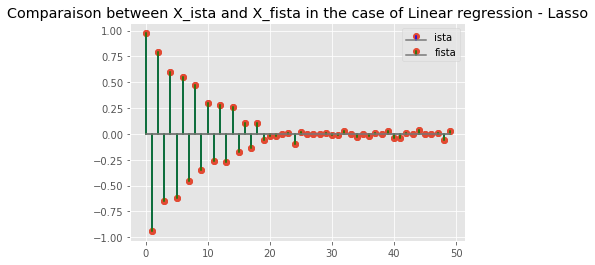

In [28]:
x_ista_linreg_lasso, obj1, err1 = ista(
    x0, loss_linreg, grad_linreg, lasso, prox_lasso, step=lip_linreg(A), s=s, n_iter=100, verbose=False)
x_fista_linreg_lasso, obj2, err2 = fista(
    x0, loss_linreg, grad_linreg, lasso, prox_lasso, step=lip_linreg(A), s=s, n_iter=100, verbose=False)
plt.stem(x_ista_linreg_lasso, label="ista", linefmt='b')
plt.stem(x_fista_linreg_lasso, label="fista", linefmt='g')
plt.legend()
plt.title(
    "Comparaison between X_ista and X_fista in the case of Linear regression - Lasso")

#### Logistic regression - Ridge 

Text(0.5,1,'Comparaison between X_ista and X_fista in the case of Logistic regression - Ridge ')

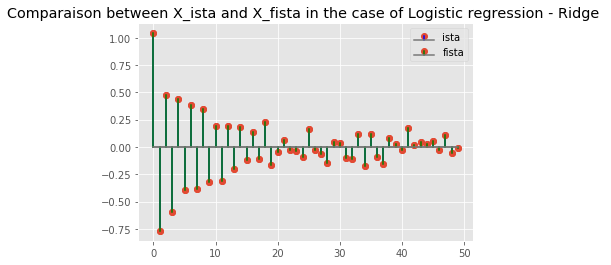

In [29]:
x_ista_logreg_ridge, obj1, err1 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step=lip_logreg(
    A_log), s=s, n_iter=100, verbose=False, x_true=x_true)
x_fista_logreg_ridge, obj2, err2 = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step=lip_logreg(
    A_log), x_true=x_true, s=s, n_iter=100, verbose=False)
plt.stem(x_ista_logreg_ridge, label="ista", linefmt='b')
plt.stem(x_fista_logreg_ridge, label="fista", linefmt='g')
plt.legend()
plt.title(
    "Comparaison between X_ista and X_fista in the case of Logistic regression - Ridge ")

#### Logistic regression - Lasso :

Text(0.5,1,'Comparaison between X_ista and X_fista in the case of Logistic regression - Lasso')

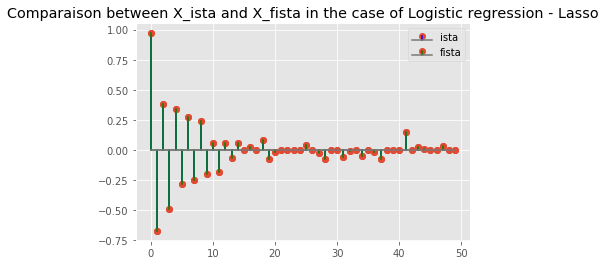

In [30]:
x_ista_logreg_lasso, obj1, err1 = ista(
    x0, loss_logreg, grad_logreg, lasso, prox_lasso, step=lip_logreg(A_log), s=s, n_iter=100, verbose=False)
x_fista_logreg_lasso, obj2, err2 = fista(
    x0, loss_logreg, grad_logreg, lasso, prox_lasso, step=lip_logreg(A_log), s=s, n_iter=100, verbose=False)
plt.stem(x_ista_logreg_lasso, label="ista", linefmt='b')
plt.stem(x_fista_logreg_lasso, label="fista", linefmt='g')
plt.legend()
plt.title(
    "Comparaison between X_ista and X_fista in the case of Logistic regression - Lasso")

**Interprétation**: 
</br> We find that, using coefs as x_true, the ISTA and FISTA algorithms converge towards the same solution.

### B) The influence of the correlation of the features on the performance of the optimization algorithms in linear regression and logistic regression.

#### Linear Regression - Ridge :

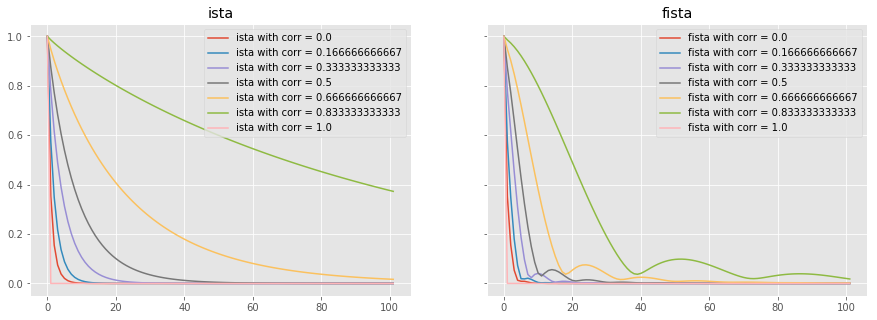

In [31]:
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(1, 2, sharey=True, figsize=(15, 5))

for i in np.linspace(0, 1, num=7):
    A, b = simu_linreg(coefs, corr=i)
    A_log, b_log = simu_logreg(coefs, corr=i)
    x_true, obj, err = ista(x0, loss_linreg, grad_linreg, ridge,
                            prox_ridge, step=lip_linreg(A), s=s, n_iter=1000, verbose=False)
    x_t, obj1, err1 = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step=lip_linreg(
        A), s=s, n_iter=100, verbose=False, x_true=x_true)
    x, obj2, err2 = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step=lip_linreg(
        A), x_true=x_true, s=s, n_iter=100, verbose=False)
    axarr[0].plot(err1, label="ista with corr = " + str(i))
    axarr[0].set_title('ista')
    axarr[0].legend()
    axarr[1].plot(err2, label="fista with corr = " + str(i))
    axarr[1].set_title('fista')
    axarr[1].legend()

#### Logistic Regression - Ridge :

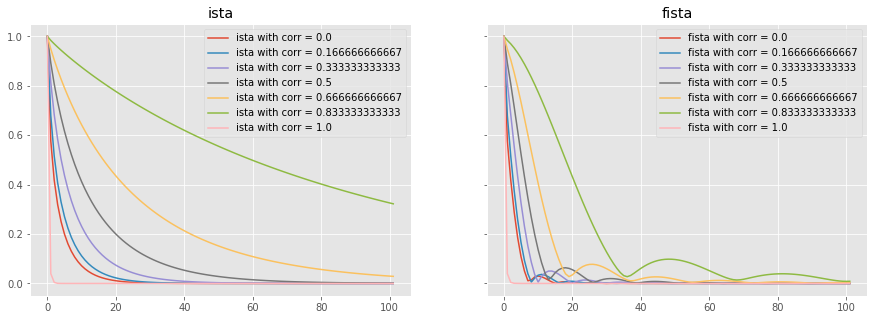

In [32]:
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(1, 2, sharey=True, figsize=(15, 5))

for i in np.linspace(0, 1, num=7):
    A, b = simu_linreg(coefs, corr=i)
    A_log, b_log = simu_logreg(coefs, corr=i)
    x_true, obj, err = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step=lip_logreg(
        A_log), s=s, n_iter=1000, verbose=False)
    x_t, obj1, err1 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step=lip_logreg(
        A_log), s=s, n_iter=100, verbose=False, x_true=x_true)
    x, obj2, err2 = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step=lip_logreg(
        A_log), x_true=x_true, s=s, n_iter=100, verbose=False)
    axarr[0].plot(err1, label="ista with corr = " + str(i))
    axarr[0].set_title('ista')
    axarr[0].legend()
    axarr[1].plot(err2, label="fista with corr = " + str(i))
    axarr[1].set_title('fista')
    axarr[1].legend()

### Linear regression - Lasso

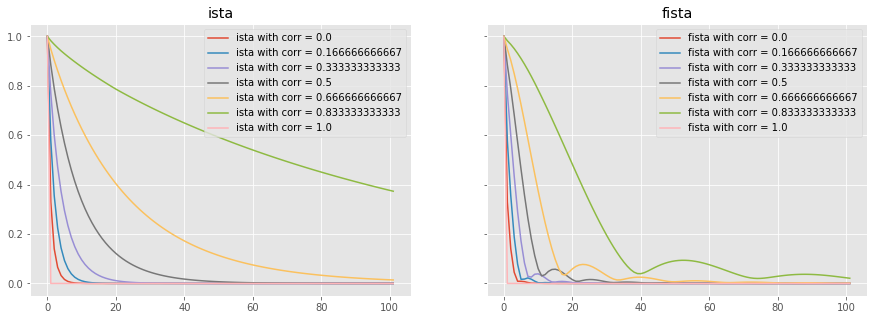

In [33]:
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(1, 2, sharey=True, figsize=(15, 5))

for i in np.linspace(0, 1, num=7):
    A, b = simu_linreg(coefs, corr=i)
    A_log, b_log = simu_logreg(coefs, corr=i)
    x_true, obj, err = ista(x0, loss_linreg, grad_linreg, lasso,
                            prox_lasso, step=lip_linreg(A), s=s, n_iter=1000, verbose=False)
    x_t, obj1, err1 = ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step=lip_linreg(
        A), s=s, n_iter=100, verbose=False, x_true=x_true)
    x, obj2, err2 = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step=lip_linreg(
        A), x_true=x_true, s=s, n_iter=100, verbose=False)
    axarr[0].plot(err1, label="ista with corr = " + str(i))
    axarr[0].set_title('ista')
    axarr[0].legend()
    axarr[1].plot(err2, label="fista with corr = " + str(i))
    axarr[1].set_title('fista')
    axarr[1].legend()

### Logistic regression - Lasso

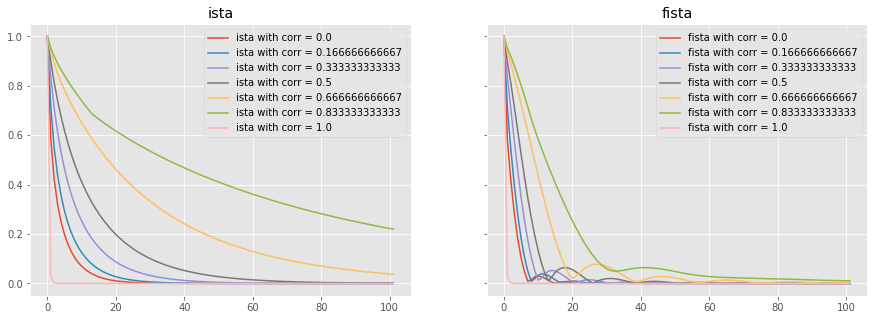

In [34]:
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(1, 2, sharey=True, figsize=(15, 5))

for i in np.linspace(0, 1, num=7):
    A, b = simu_linreg(coefs, corr=i)
    A_log, b_log = simu_logreg(coefs, corr=i)
    x_true, obj, err = ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step=lip_logreg(
        A_log), s=s, n_iter=1000, verbose=False)
    x_t, obj1, err1 = ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step=lip_logreg(
        A_log), s=s, n_iter=100, verbose=False, x_true=x_true)
    x, obj2, err2 = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step=lip_logreg(
        A_log), x_true=x_true, s=s, n_iter=100, verbose=False)
    axarr[0].plot(err1, label="ista with corr = " + str(i))
    axarr[0].set_title('ista')
    axarr[0].legend()
    axarr[1].plot(err2, label="fista with corr = " + str(i))
    axarr[1].set_title('fista')
    axarr[1].legend()

** Interprétation: **

We note that the speed of convergence of these 2 algorithms is inversely proportional to the correlation, ie when we increase the correlation, the algorithm converges less rapidly and vice versa.
in fact , we know that : 
$$||x^{t+1}-x^*||_2 < (1-cond(A))^t||x^{0}-x^*||_2$$
</br> when the correlation decreases the condition number increases . therefore we have a speeder convergence and vice versa.

## C) The influence of the level of ridge penalization on the performance of the optimization algorithms. 

### Ridge

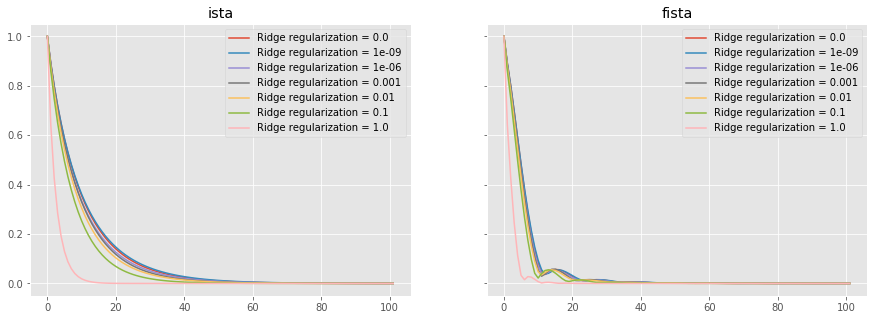

In [35]:
s_ridge = np.array([0, 1e-9, 1e-6, 1e-3, 1e-2, 1e-1, 1])
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(1, 2, sharey=True, figsize=(15, 5))


for pen in s_ridge:
    A, b = simu_linreg(coefs)
    A_log, b_log = simu_logreg(coefs)
    x_true, obj, err = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step=lip_linreg(
        A), s=pen, n_iter=1000, verbose=False)
    x_t, obj1, err1 = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step=lip_linreg(
        A), s=pen, n_iter=100, verbose=False, x_true=x_true)
    x, obj2, err2 = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step=lip_linreg(
        A), x_true=x_true, s=pen, n_iter=100, verbose=False)
    axarr[0].plot(err1, label="Ridge regularization = " + str(pen))
    axarr[0].set_title('ista')
    axarr[0].legend()
    axarr[1].plot(err2, label="Ridge regularization = " + str(pen))
    axarr[1].set_title('fista')
    axarr[1].legend()

### Lasso

C:\Users\mejri aymen\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\mejri aymen\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\mejri aymen\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
C:\Users\mejri aymen\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


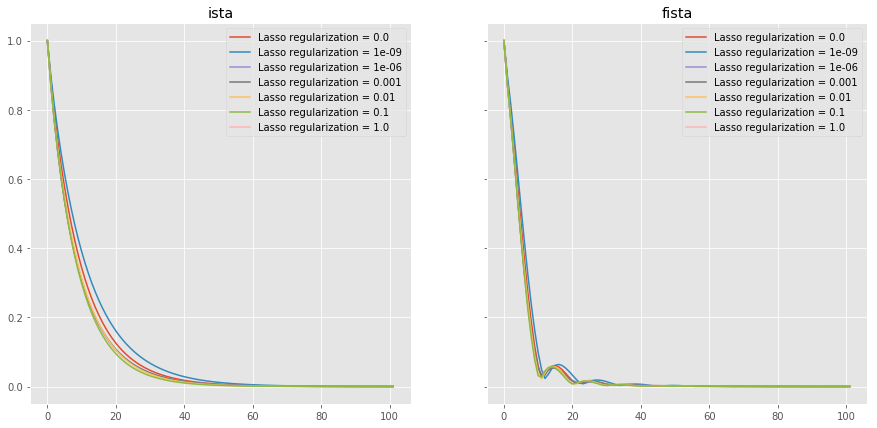

In [36]:
s_lasso = np.array([0, 1e-9, 1e-6, 1e-3, 1e-2, 1e-1, 1])
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(1, 2, sharey=True, figsize=(15, 7))


for pen in s_lasso:
    A, b = simu_linreg(coefs)
    A_log, b_log = simu_logreg(coefs)
    x_true, obj, err = ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step=lip_linreg(
        A), s=pen, n_iter=1000, verbose=False)
    x_t, obj1, err1 = ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step=lip_linreg(
        A), s=pen, n_iter=100, verbose=False, x_true=x_true)
    x, obj2, err2 = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step=lip_linreg(
        A), x_true=x_true, s=pen, n_iter=100, verbose=False)
    axarr[0].plot(err1, label="Lasso regularization = " + str(pen))
    axarr[0].set_title('ista')
    axarr[0].legend()
    axarr[1].plot(err2, label="Lasso regularization = " + str(pen))
    axarr[1].set_title('fista')
    axarr[1].legend()

** Interpretation: **

We note that the speed of convergence of these 2 algorithms is proportional to the level of penalization(for ridge and lasso), ie when we increase the level of penalization, the algorithm converges more rapidly and vice versa.

##D) Comparaison between the performance of the optimization algorithms for ridge and lasso penalizations.

### Linear regression

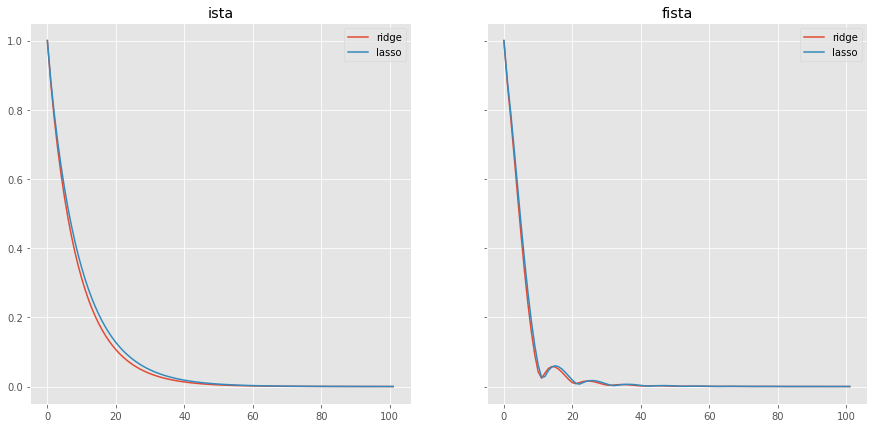

In [37]:
type_reg = [ridge, lasso]
type_prox = [prox_ridge, prox_lasso]
l = ['ridge', 'lasso']
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(1, 2, sharey=True, figsize=(15, 7))


for i in range(2):
    A, b = simu_linreg(coefs)
    A_log, b_log = simu_logreg(coefs)
    x_true, obj, err = ista(x0, loss_linreg, grad_linreg, type_reg[i], type_prox[i], step=lip_linreg(
        A), s=s, n_iter=1000, verbose=False)
    x_t, obj1, err1 = ista(x0, loss_linreg, grad_linreg, type_reg[i], type_prox[i], step=lip_linreg(
        A), s=s, n_iter=100, verbose=False, x_true=x_true)
    x, obj2, err2 = fista(x0, loss_linreg, grad_linreg, type_reg[i], type_prox[i], step=lip_linreg(
        A), x_true=x_true, s=s, n_iter=100, verbose=False)
    axarr[0].plot(err1, label=l[i])
    axarr[0].set_title('ista')
    axarr[0].legend()
    axarr[1].plot(err2, label=l[i])
    axarr[1].set_title('fista')
    axarr[1].legend()

### Logistic Regression

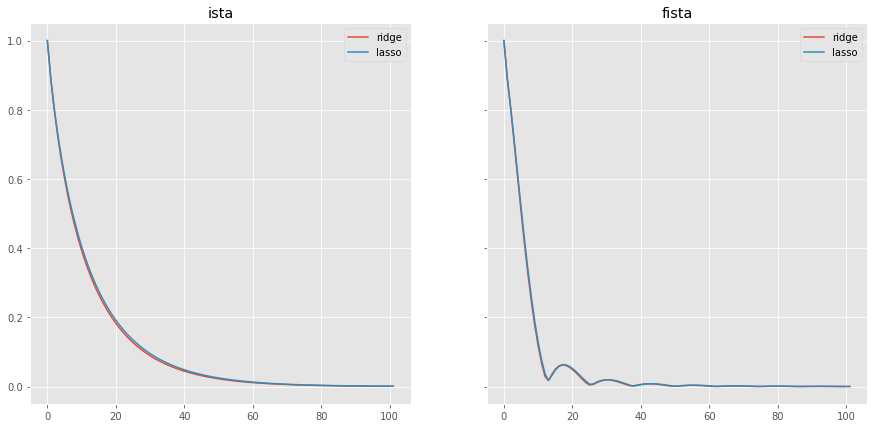

In [38]:
type_reg = [ridge, lasso]
type_prox = [prox_ridge, prox_lasso]

l = ['ridge', 'lasso']
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(1, 2, sharey=True, figsize=(15, 7))


for i in range(2):
    A, b = simu_linreg(coefs)
    A_log, b_log = simu_logreg(coefs)
    x_true, obj, err = ista(x0, loss_logreg, grad_logreg, type_reg[i], type_prox[i], step=lip_logreg(
        A_log), s=s, n_iter=1000, verbose=False)
    x_t, obj1, err1 = ista(x0, loss_logreg, grad_logreg, type_reg[i], type_prox[i], step=lip_logreg(
        A_log), s=s, n_iter=100, verbose=False, x_true=x_true)
    x, obj2, err2 = fista(x0, loss_logreg, grad_logreg, type_reg[i], type_prox[i], step=lip_logreg(
        A_log), x_true=x_true, s=s, n_iter=100, verbose=False)
    axarr[0].plot(err1, label=l[i])
    axarr[0].set_title('ista')
    axarr[0].legend()
    axarr[1].plot(err2, label=l[i])
    axarr[1].set_title('fista')
    axarr[1].legend()

** Interprétation: **
</br>
The performance of the optimization algorithms for ridge and lasso penalizations are  almost the same.